In [1]:
import os
import zipfile
from PIL import Image
import numpy as np
from io import BytesIO
import matplotlib.pyplot as plt
import gc
from zip_data_loader import load_images_as_list_of_dicts, test_format

zip_images_list = load_images_as_list_of_dicts("pictures")

ZIP: 14-7-35.zip has 20 images
  Image 1 shape: (3024, 4032, 3)
  Image 2 shape: (3024, 4032, 3)
  Image 3 shape: (3024, 4032, 3)
  Image 4 shape: (3024, 4032, 3)
  Image 5 shape: (3024, 4032, 3)
  Image 6 shape: (3024, 4032, 3)
  Image 7 shape: (3024, 4032, 3)
  Image 8 shape: (3024, 4032, 3)
  Image 9 shape: (3024, 4032, 3)
  Image 10 shape: (3024, 4032, 3)
  Image 11 shape: (3024, 4032, 3)
  Image 12 shape: (3024, 4032, 3)
  Image 13 shape: (3024, 4032, 3)
  Image 14 shape: (3024, 4032, 3)
  Image 15 shape: (3024, 4032, 3)
  Image 16 shape: (3024, 4032, 3)
  Image 17 shape: (3024, 4032, 3)
  Image 18 shape: (3024, 4032, 3)
  Image 19 shape: (3024, 4032, 3)
  Image 20 shape: (3024, 4032, 3)
ZIP: 15-15-15.zip has 20 images
  Image 1 shape: (3024, 4032, 3)
  Image 2 shape: (3024, 4032, 3)
  Image 3 shape: (3024, 4032, 3)
  Image 4 shape: (3024, 4032, 3)
  Image 5 shape: (3024, 4032, 3)
  Image 6 shape: (3024, 4032, 3)
  Image 7 shape: (3024, 4032, 3)
  Image 8 shape: (3024, 4032, 3)
  

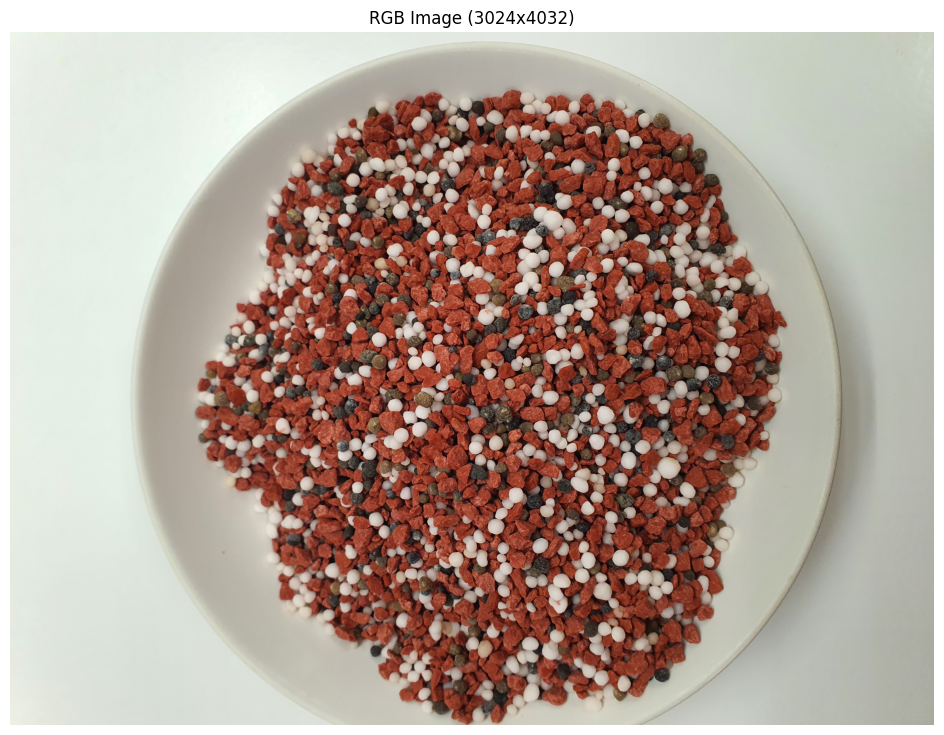

In [2]:
import matplotlib.pyplot as plt

# Your array shape: (3024, 4032, 3)
plt.figure(figsize=(12, 9))  # Adjust figure size for better viewing
plt.imshow(zip_images_list[0]['images'][0])
plt.axis('off')
plt.title('RGB Image (3024x4032)')
plt.show()

Original image size: 3024x4032
Downsampled to: 136x182 (scale: 0.045)
Using 24752 pixels for clustering
Using 4 color groups
Group 1: 25 potential bearings
Group 2: 25 potential bearings
Group 3: 25 potential bearings
Group 4: 25 potential bearings
Resizing image for SAM: 866x1154
Processing group 1: 25 centers...
Processing group 2: 25 centers...
Processing group 3: 25 centers...
Processing group 4: 25 centers...

Total bearings detected: 100


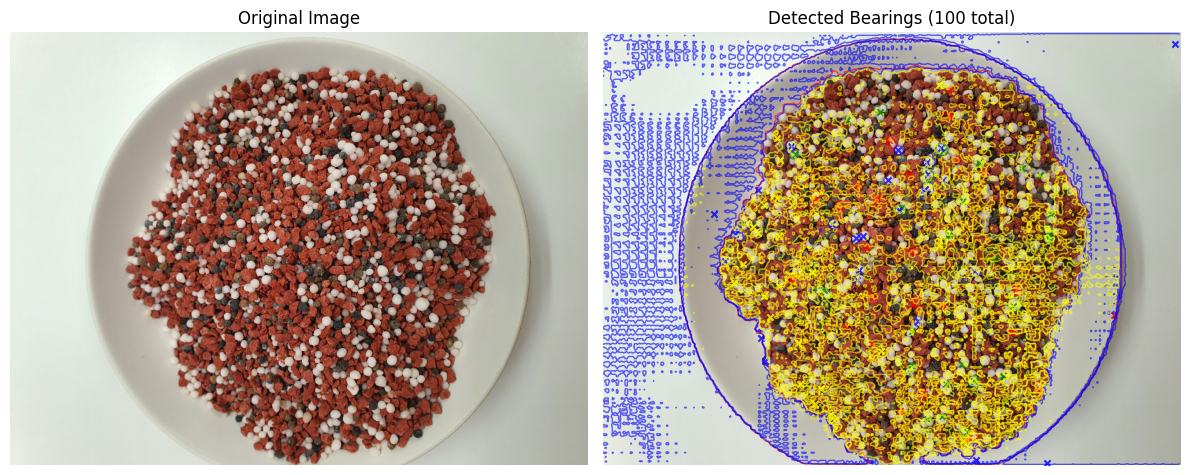

Memory cleanup completed!


In [3]:
from sklearn.cluster import KMeans, MiniBatchKMeans
from segment_anything import sam_model_registry, SamPredictor
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import gc  # Garbage collection

def downsample_for_clustering(image_np, max_pixels=50000):
    """Downsample image for clustering to reduce memory usage"""
    H, W = image_np.shape[:2]
    total_pixels = H * W
    
    if total_pixels <= max_pixels:
        return image_np, 1.0
    
    # Calculate downsampling factor
    scale = np.sqrt(max_pixels / total_pixels)
    new_H, new_W = int(H * scale), int(W * scale)
    
    # Downsample image
    downsampled = cv2.resize(image_np, (new_W, new_H), interpolation=cv2.INTER_AREA)
    return downsampled, scale

def process_image_in_chunks(image_np, chunk_size=1000):
    """Process large images in smaller chunks to save memory"""
    H, W = image_np.shape[:2]
    
    # If image is small enough, process normally
    if H * W <= chunk_size * chunk_size:
        return image_np.reshape(-1, 3)
    
    # Process in overlapping chunks
    pixels_list = []
    step = chunk_size // 2  # Overlap by 50%
    
    for y in range(0, H, step):
        for x in range(0, W, step):
            # Extract chunk
            y_end = min(y + chunk_size, H)
            x_end = min(x + chunk_size, W)
            chunk = image_np[y:y_end, x:x_end]
            
            # Sample pixels from chunk (not all pixels)
            chunk_pixels = chunk.reshape(-1, 3)
            if len(chunk_pixels) > 1000:  # Sample if chunk is large
                indices = np.random.choice(len(chunk_pixels), 1000, replace=False)
                chunk_pixels = chunk_pixels[indices]
            
            pixels_list.append(chunk_pixels)
    
    return np.vstack(pixels_list)

# Load image
image_np = zip_images_list[0]['images'][0]
original_H, original_W = image_np.shape[:2]

print(f"Original image size: {original_H}x{original_W}")

# === Step 1: Memory-efficient color clustering ===
# Downsample for clustering
downsampled_img, scale_factor = downsample_for_clustering(image_np, max_pixels=25000)
print(f"Downsampled to: {downsampled_img.shape[0]}x{downsampled_img.shape[1]} (scale: {scale_factor:.3f})")

# Use MiniBatchKMeans for large datasets (much more memory efficient)
pixels_sample = process_image_in_chunks(downsampled_img, chunk_size=500)
print(f"Using {len(pixels_sample)} pixels for clustering")

# Determine number of groups (simple heuristic)
n_groups = min(4, max(2, len(pixels_sample) // 5000))
print(f"Using {n_groups} color groups")

# Use MiniBatchKMeans - much more memory efficient than regular KMeans
kmeans_groups = MiniBatchKMeans(
    n_clusters=n_groups, 
    random_state=42, 
    batch_size=1000,  # Process in small batches
    max_iter=100      # Reduce iterations
).fit(pixels_sample)

# Apply clustering to full image in chunks to save memory
def apply_clustering_chunked(image, kmeans_model, chunk_size=50000):
    """Apply clustering to image in chunks to save memory"""
    H, W = image.shape[:2]
    result = np.zeros((H, W), dtype=np.int32)
    
    total_pixels = H * W
    
    if total_pixels <= chunk_size:
        # Small image - process normally
        pixels = image.reshape(-1, 3)
        labels = kmeans_model.predict(pixels)
        return labels.reshape(H, W)
    
    # Large image - process in chunks
    pixels_per_row = W
    rows_per_chunk = max(1, chunk_size // pixels_per_row)
    
    for start_row in range(0, H, rows_per_chunk):
        end_row = min(start_row + rows_per_chunk, H)
        chunk = image[start_row:end_row]
        
        pixels = chunk.reshape(-1, 3)
        labels = kmeans_model.predict(pixels)
        result[start_row:end_row] = labels.reshape(chunk.shape[0], chunk.shape[1])
        
        # Clear memory
        del pixels, labels, chunk
        gc.collect()
    
    return result

group_labels = apply_clustering_chunked(image_np, kmeans_groups)

# === Step 2: Efficient center extraction ===
all_centers_per_group = []
max_centers_per_group = 25  # Limit to prevent memory issues

for group_id in range(n_groups):
    mask_group = (group_labels == group_id)
    
    # Use morphological operations to find connected components efficiently
    mask_uint8 = mask_group.astype(np.uint8)
    
    # Find contours instead of clustering all pixels
    contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    centers = []
    # Sort contours by area and take the largest ones
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    
    for contour in contours[:max_centers_per_group]:  # Limit number of objects
        area = cv2.contourArea(contour)
        if area < 50:  # Skip very small areas
            continue
            
        # Calculate centroid
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            centers.append([cx, cy])
    
    all_centers_per_group.append(centers)
    print(f"Group {group_id + 1}: {len(centers)} potential bearings")

# === Step 3: Memory-efficient SAM processing ===
model_type = "vit_b"
checkpoint_path = "sam_vit_b_01ec64.pth"
device = "cuda" if torch.cuda.is_available() else "cpu"

# Clear some memory before loading SAM
del pixels_sample, downsampled_img
gc.collect()

# Enable memory-efficient settings for PyTorch
if torch.cuda.is_available():
    torch.cuda.empty_cache()

try:
    sam = sam_model_registry[model_type](checkpoint=checkpoint_path).to(device)
    predictor = SamPredictor(sam)
    
    # Process image in smaller resolution for SAM if too large
    if original_H * original_W > 1000000:  # 1MP threshold
        sam_scale = np.sqrt(1000000 / (original_H * original_W))
        sam_h, sam_w = int(original_H * sam_scale), int(original_W * sam_scale)
        sam_image = cv2.resize(image_np, (sam_w, sam_h))
        print(f"Resizing image for SAM: {sam_h}x{sam_w}")
    else:
        sam_image = image_np
        sam_scale = 1.0
    
    predictor.set_image(sam_image)
    
    all_masks_per_group = []
    total_processed = 0
    
    for group_id, centers in enumerate(all_centers_per_group):
        masks_for_group = []
        print(f"Processing group {group_id + 1}: {len(centers)} centers...")
        
        for i, center in enumerate(centers):
            try:
                # Scale center coordinates if image was resized
                scaled_center = [int(center[0] * sam_scale), int(center[1] * sam_scale)]
                
                input_point = np.array([scaled_center])
                input_label = np.array([1])
                
                # Use single mask output to save memory
                masks, scores, _ = predictor.predict(
                    point_coords=input_point,
                    point_labels=input_label,
                    multimask_output=False
                )
                
                # Resize mask back to original size if needed
                if sam_scale != 1.0:
                    mask_resized = cv2.resize(
                        masks[0].astype(np.uint8), 
                        (original_W, original_H), 
                        interpolation=cv2.INTER_NEAREST
                    ).astype(bool)
                    masks_for_group.append(mask_resized)
                else:
                    masks_for_group.append(masks[0])
                
                total_processed += 1
                
                # Clear GPU memory periodically
                if total_processed % 10 == 0:
                    if torch.cuda.is_available():
                        torch.cuda.empty_cache()
                    gc.collect()
                
            except Exception as e:
                print(f"Error processing center {center}: {e}")
                continue
        
        all_masks_per_group.append(masks_for_group)
        
except Exception as e:
    print(f"Error with SAM: {e}")
    all_masks_per_group = [[] for _ in range(n_groups)]

# === Step 4: Memory-efficient visualization ===
total_bearings = sum(len(masks) for masks in all_masks_per_group)
print(f"\nTotal bearings detected: {total_bearings}")

# Create a more memory-efficient visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Original image (possibly downsampled for display)
display_scale = 1.0
if original_H > 1000 or original_W > 1000:
    display_scale = min(1000/original_H, 1000/original_W)
    display_img = cv2.resize(image_np, None, fx=display_scale, fy=display_scale)
else:
    display_img = image_np

axes[0].imshow(display_img)
axes[0].set_title("Original Image")
axes[0].axis('off')

# Segmentation results
axes[1].imshow(display_img)
colors = ['red', 'green', 'blue', 'yellow', 'purple', 'orange']

for group_id, (centers, masks) in enumerate(zip(all_centers_per_group, all_masks_per_group)):
    color = colors[group_id % len(colors)]
    
    # Plot centers (scaled for display)
    if centers:
        centers_array = np.array(centers) * display_scale
        axes[1].scatter(centers_array[:, 0], centers_array[:, 1], 
                       c=color, s=20, alpha=0.8, marker='x')
    
    # Plot mask contours (sample every few masks to avoid overload)
    step = max(1, len(masks) // 10)  # Show at most 10 masks per group
    for i in range(0, len(masks), step):
        mask = masks[i]
        if display_scale != 1.0:
            mask = cv2.resize(mask.astype(np.uint8), None, 
                            fx=display_scale, fy=display_scale).astype(bool)
        axes[1].contour(mask, colors=[color], linewidths=1, alpha=0.6)

axes[1].set_title(f"Detected Bearings ({total_bearings} total)")
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Clean up memory
del sam, predictor
if torch.cuda.is_available():
    torch.cuda.empty_cache()
gc.collect()

print("Memory cleanup completed!")